In [117]:
import osrs_GE

import numpy as np
import pandas as pd

from datetime import datetime

import seaborn as sns

from osrs_GE import elliptic_paraboloid_loss as eploss

import matplotlib.pyplot as plt

#### To-do
- Algorithmic way of determining return thresholds for classification?
    - Should be solely based off of some trailing vol ema

In [75]:
# dragonfire shield
item_id = 11284
freq = '6h'


item_name = osrs_GE.item_name_from_id(item_id)
df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP
date,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06


In [77]:
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet_y
date,,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06,-0.006633
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06,-0.047092
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06,0.000898
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06,0.005086
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06,-0.003957


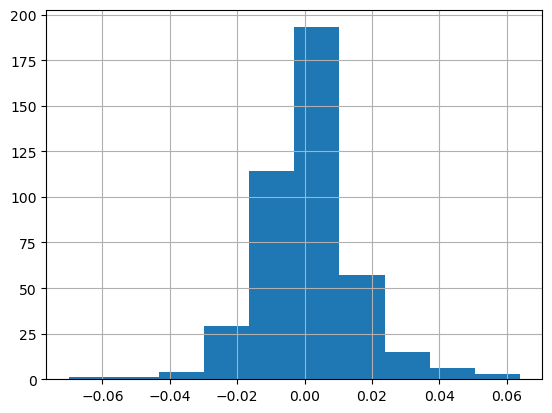

In [79]:
df['simpRet_y'].hist()
plt.show()

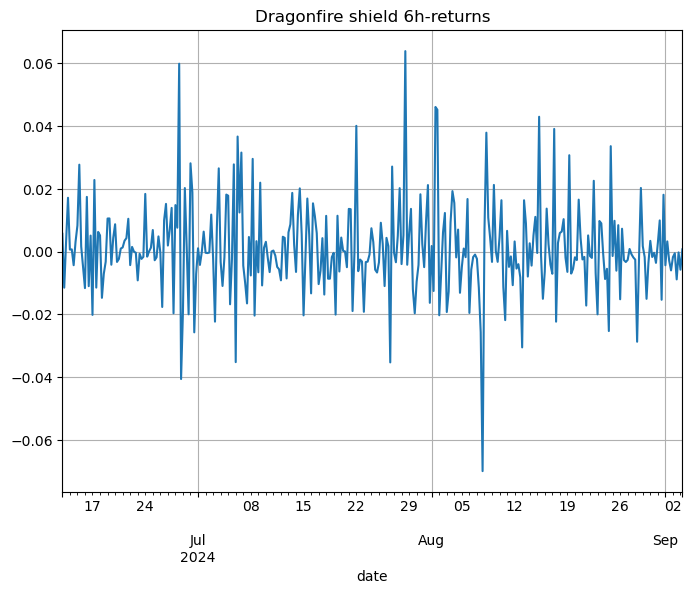

In [81]:
df_tr['simpRet_y'].plot(figsize=(8,6))
plt.title("{0} {1}-returns".format(item_name,freq))
plt.grid()
plt.show()

In [83]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_tr['simpRet_y'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-16.339
p-value:0.0000
lags:1


In [85]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet_y'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1865.181, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1856.541, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1858.363, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1860.547, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1864.929, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1866.101, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1863.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1867.798, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1867.320, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1865.064, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1868.645, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1858.288, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1868.622, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1867.372, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0

In [87]:
p,d,q = auto_res.order

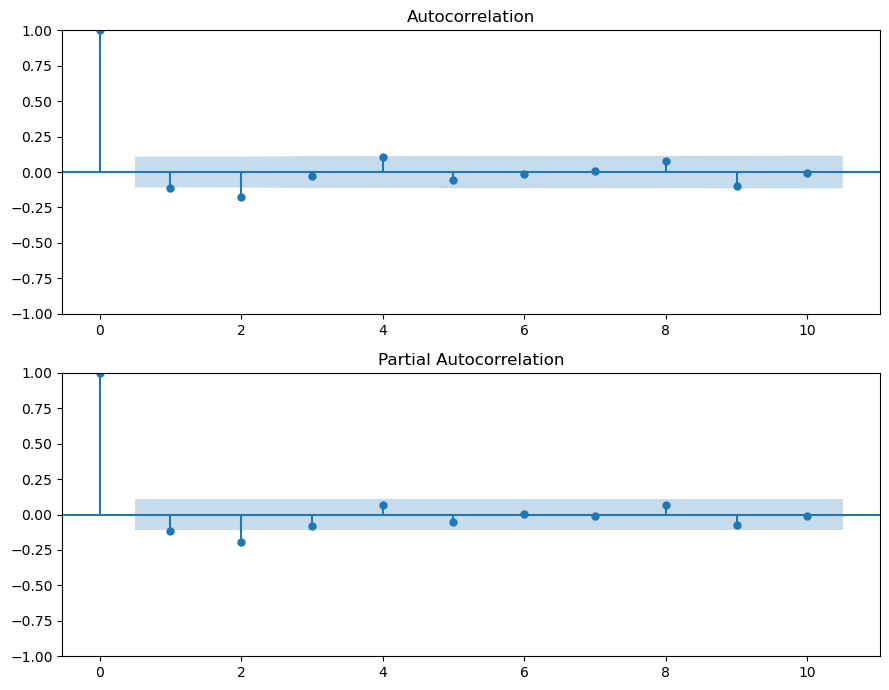

In [89]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet_y'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet_y'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

In [91]:
### Creating features
#### parameters

RSI_window = 5
MACD_short = 3
MACD_long = 8
lagged_rets = 5

if freq == '6h':
    RSI_window = 10
    MACD_short = 4
    MACD_long = 16


##### Lagged returns
for k in range(1,lagged_rets+1):
    df['simpRet_'+str(k)] = df['simpRet_y'].shift(k)


##### RSI
df = osrs_GE.compute_RSI(df,window = RSI_window,col_name = 'VWAP')


##### Order Imbalance
df['OI'] = df['highPriceVolume'] -  df['lowPriceVolume']
df['OI*'] = df['OI']*((df['avgHighPrice'] > df['avgLowPrice'])*1 - (df['avgHighPrice'] < df['avgLowPrice']))
df['OI_ratio'] = df['OI']/(df['highPriceVolume'] + df['lowPriceVolume'])


##### Spread
df['Spread'] = df['avgHighPrice'] - df['avgLowPrice']
df['SpreadPct'] = df['Spread']/df['VWAP']


##### Cross Metric - interaction between the OI and the actively traded price spread
df['CM'] = df['SpreadPct']*df['OI']


##### MACD
df = osrs_GE.compute_MACD(df,st_n=MACD_short,lt_n=MACD_long, drop_ema_cols = False)
df['VWAP/ema'+str(MACD_short)] = df['VWAP']/df['VWAP_ema'+str(MACD_short)]
df['VWAP/ema'+str(MACD_long)] = df['VWAP']/df['VWAP_ema'+str(MACD_long)]
df['VWAP_nMACD_{0}_{1}'.format(MACD_short,MACD_long)] = df['VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)]/df['VWAP']


df = df.drop(['timestamp','avgHighPrice','avgLowPrice','highPriceVolume',
            'lowPriceVolume','VWAP','VWAP_diff','OI*','Spread','VWAP_ema'+str(MACD_short),
            'VWAP_ema'+str(MACD_long),'VWAP_MACD_{0}_{1}'.format(MACD_short,MACD_long)],axis=1)

df = df.dropna()

df.head()

,simpRet_y,simpRet_1,simpRet_2,simpRet_3,simpRet_4,simpRet_5,VWAP_RSI10,OI,OI_ratio,SpreadPct,CM,VWAP/ema4,VWAP/ema16,VWAP_nMACD_4_16
date,,,,,,,,,,,,,,
2024-06-13 00:00:00,0.005685,-0.005970,-0.001374,-0.000367,0.006588,-0.006389,28.204822,-3,-0.006160,0.010799,-0.032398,0.995829,0.989546,-0.006376
2024-06-13 06:00:00,-0.011487,0.005685,-0.005970,-0.001374,-0.000367,0.006588,28.792980,160,0.375587,0.006632,1.061199,1.000892,0.995900,-0.005009
2024-06-13 12:00:00,0.003358,-0.011487,0.005685,-0.005970,-0.001374,-0.000367,47.990845,16,0.033755,0.016352,0.261632,0.993616,0.986705,-0.007049
2024-06-13 18:00:00,0.017145,0.003358,-0.011487,0.005685,-0.005970,-0.001374,51.113301,77,0.117199,0.016214,1.248510,0.998170,0.991427,-0.006814
2024-06-14 00:00:00,0.000640,0.017145,0.003358,-0.011487,0.005685,-0.005970,62.258941,69,0.128015,0.018791,1.296571,1.009112,1.007246,-0.001835


In [93]:
df.shape

(413, 14)

In [95]:
# create train test split
train_idx = int(.8*df.index.shape[0])
train_dt = df.index[train_idx]
#train_dt = '2024-05-19'

df_tr = df[df.index < train_dt]
df_tr.shape

(330, 14)

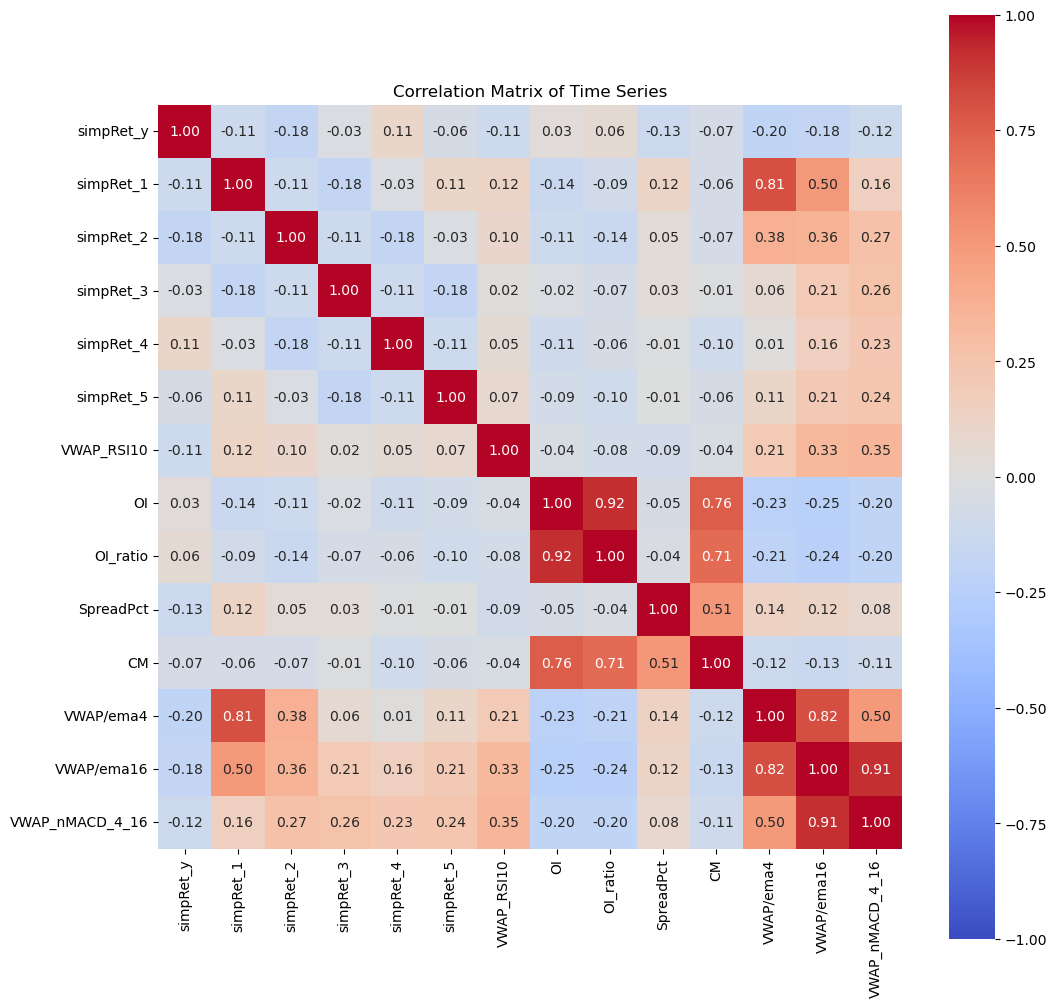

In [97]:
corr_matrix = df_tr.corr()

plt.figure(figsize=(12,12))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,vmax=1)

plt.title('Correlation Matrix of Time Series')
plt.show()

# Return forecasting

## Feature selection for linear models

In [101]:
## Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

X = df_tr.drop('simpRet_y',axis=1).values
y = df_tr['simpRet_y'].values

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [103]:
names=df_tr.drop("simpRet_y", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['simpRet_1' 'simpRet_2' 'simpRet_3' 'simpRet_4' 'simpRet_5' 'VWAP_RSI10'
 'OI' 'OI_ratio' 'SpreadPct' 'CM' 'VWAP/ema4' 'VWAP/ema16'
 'VWAP_nMACD_4_16']


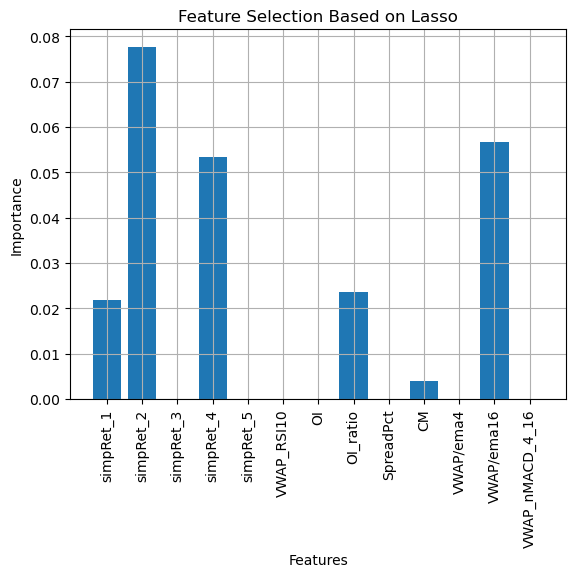

In [105]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [107]:
# Subsetting the features that are relevant.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, 'simpRet_y')
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16']
Selected Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema16'
 'simpRet_y']


In [109]:
df_tr_new = df_tr[feature_subset]
df_tr_new.head()

,simpRet_1,simpRet_2,simpRet_4,OI_ratio,CM,VWAP/ema16,simpRet_y
date,,,,,,,
2024-06-13 00:00:00,-0.005970,-0.001374,0.006588,-0.006160,-0.032398,0.989546,0.005685
2024-06-13 06:00:00,0.005685,-0.005970,-0.000367,0.375587,1.061199,0.995900,-0.011487
2024-06-13 12:00:00,-0.011487,0.005685,-0.001374,0.033755,0.261632,0.986705,0.003358
2024-06-13 18:00:00,0.003358,-0.011487,-0.005970,0.117199,1.248510,0.991427,0.017145
2024-06-14 00:00:00,0.017145,0.003358,0.005685,0.128015,1.296571,1.007246,0.000640


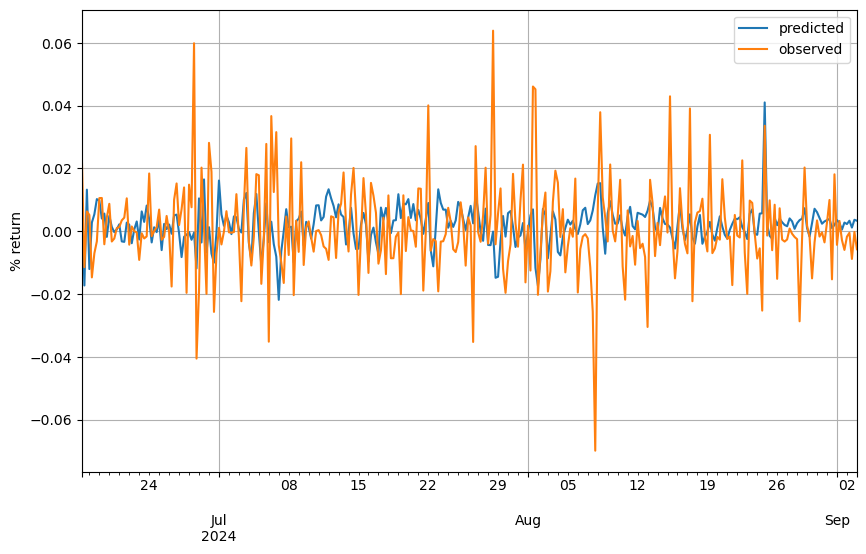



Mean EPLoss:  0.0011058549370676857


In [139]:
start_point = 10 + len(feature_subset)
X_tr = df_tr_new.drop('simpRet_y',axis=1).values
y_tr = df_tr_new['simpRet_y'].values
model = LinearRegression()

feature_shape = X_tr.shape[1]

errors = []
preds = []
obs = []
index = []

for i in range(start_point,X_tr.shape[0]-1):
    # train on data up to i-1
    _X = X_tr[:i]
    _y = y_tr[:i]
    model_fit = model.fit(_X,_y)
    
    # predict i
    x_predict = X_tr[[i]]
    y_hat = model_fit.predict(x_predict)[0]
    y_obs = y_tr[i]
    
    # record errors
    errors.append(y_obs - y_hat)
    preds.append(y_hat)
    obs.append(y_obs)
    
    index.append(df_tr_new.index[i])

df_err = pd.DataFrame({'errors': errors,
                       'predicted': preds,
                       'observed': obs}, index=index)

df_err[['predicted','observed']].plot(figsize=(10,6))
plt.ylabel("% return")
plt.grid()
plt.show()
print('\n')
print("Mean EPLoss: ",
      eploss(df_err['predicted'],df_err['observed'],c_diff_sign=5).mean())